In [1]:
import re
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment

from wordcloud import WordCloud


plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

from env import *
from acquire import *
from prepare import *
from explore import *

## 1. Spam Data

### a. Load the spam data set

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

> - They look significantly different

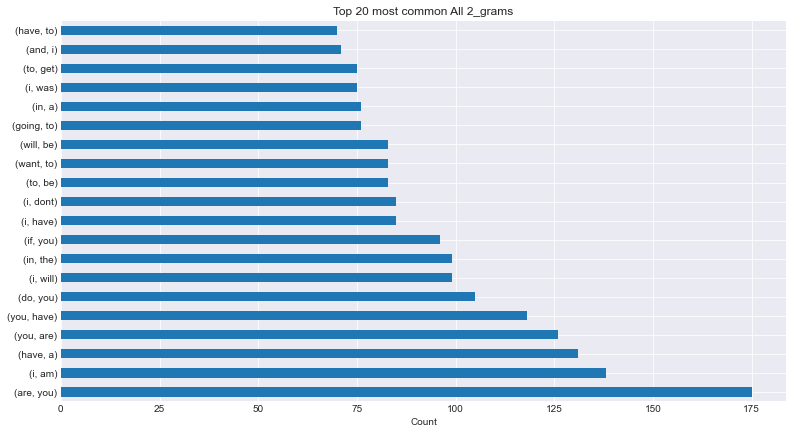

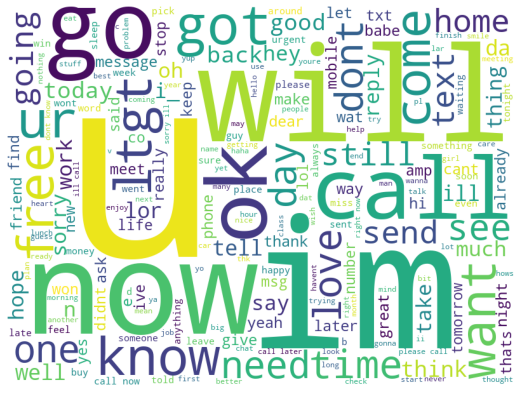

In [3]:
hns = NLP_explore(df, 'label', 'text', 'ham', 'spam')
# Generate a bigram and plot it 
hns.n_gram()
# Generate a wordcloud
hns.plot_wordcloud()

### c. Is there any overlap in the bigrams for the spam data and the ham data?
> - Yes there are over 7,799 combinations that overlap

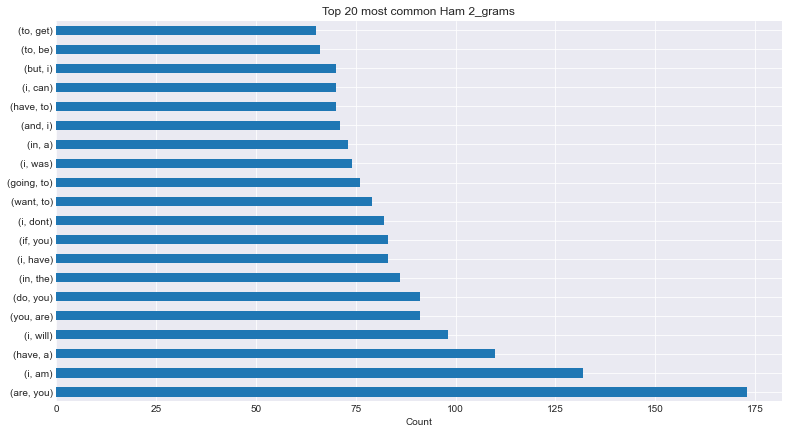

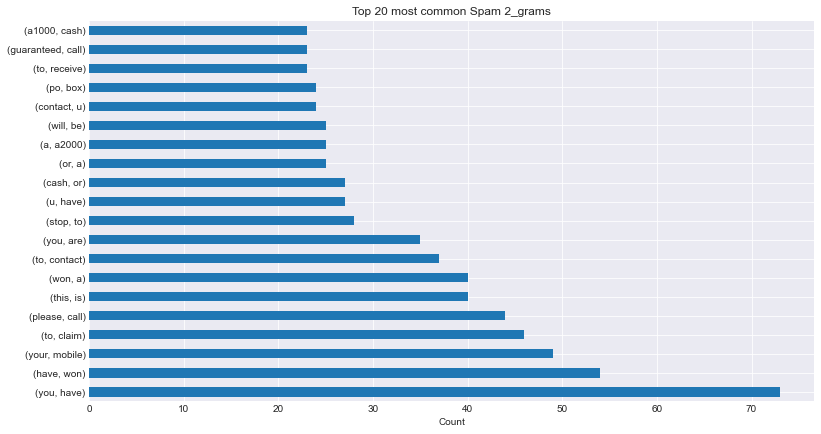

In [4]:
ham_bigram = hns.n_gram(col='ham')
spam_bigram = hns.n_gram(col='spam')
overlap = [n for n in ham_bigram if n in spam_bigram]

In [5]:
print('Ham bigram', len(ham_bigram))
print('Spam Bigram', len(ham_bigram))
print('Overlap', len(overlap))

Ham bigram 67520
Spam Bigram 67520
Overlap 7799


### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

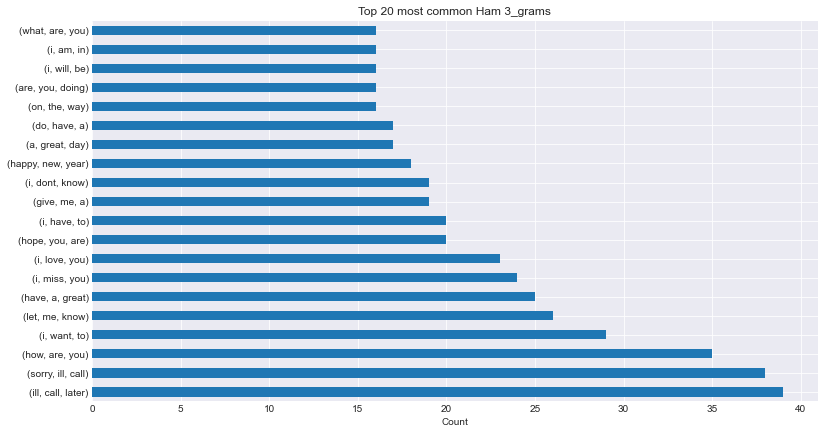

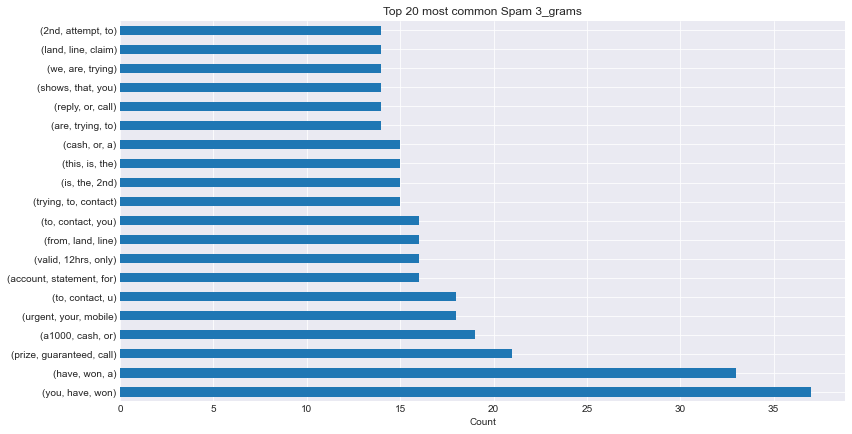

Ham trigram 67519
Spam trigram 67519
Overlap 475


In [6]:
ham_trigram = hns.n_gram(col='ham', n=3)
spam_trigram = hns.n_gram(col='spam', n=3)
overlap = [n for n in ham_trigram if n in spam_trigram]
print('Ham trigram', len(ham_trigram))
print('Spam trigram', len(ham_trigram))
print('Overlap', len(overlap))

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [7]:
# Pull in dataframe and filter label column to include titles with the name
blog_df = get_codeup_blogs()
label = 'data'
blog_df['title'] = blog_df.title.apply(lambda x: basic_clean(str(x)))
word_counts = pd.DataFrame(pd.Series(blog_df.title.str.cat(sep=' ').split()), columns=['word_counts']).value_counts()
word_counts.head(20)
# Check if there is the string 'Blog' in title
def filter_titles(s):
    # Pull title string and split to check what words are in the title
    t = str(s['title']).lower().split()

    # Check if the word blog is in the title to filter into a category
    if label in t:
        return label
    else:
        return f'not_{label}'

blog_df['label'] = blog_df.apply(filter_titles, axis=1)
blog_df.head()

,parsed,original,title,label
url,,,,
https://codeup.com/blog/,True,"Oct 28, 2021 | IT Training, Tips for Prospecti...",blog codeup,not_data
https://codeup.com/codeup-news/codeup-acquires-rackspace-cloud-academy/,True,"Apr 16, 2021 | Codeup NewsWe are thrilled to o...",codeup acquires rackspace cloud academy codeup,not_data
https://codeup.com/codeup-news/start-a-new-career-with-vet-tec/,True,"Apr 5, 2021 | Codeup NewsAre you a veteran loo...",start a new career with vet tec codeup,not_data
https://codeup.com/blog/page/2/?et_blog,True,"Oct 3, 2021 | Behind the BillboardsSep 16, 202...",blog codeup,not_data
https://codeup.com/,True,Go from no experience to employed tech profess...,best tech career accelerator in texas codeup,not_data


In [8]:
blog_df[blog_df.label == label].shape

(22, 4)

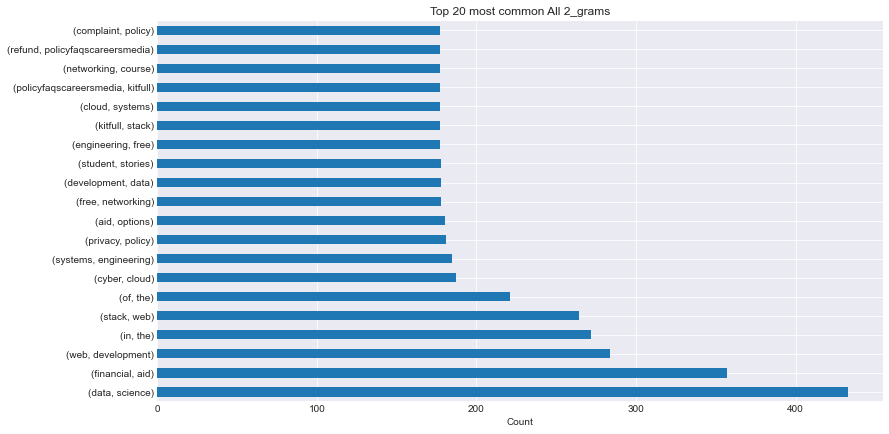

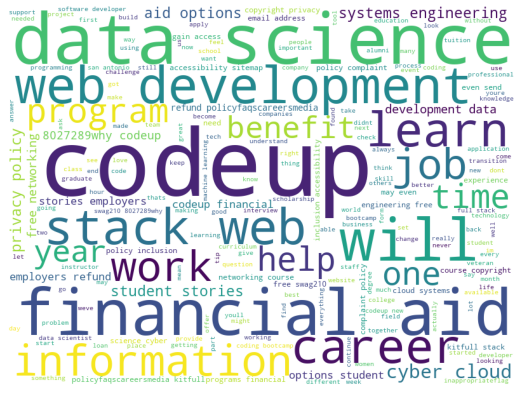

In [9]:
Blog = NLP_explore(blog_df, 'label', 'original', 'data', 'not_data')
# Generate a bigram and plot it 
Blog.n_gram()
# Generate a wordcloud
Blog.plot_wordcloud()

In [10]:
# Let's look at the frequency of the words in the articles 
Blog.word_counts.head()

,data,not_data,all
to,510,3092,3602
and,463,2467,2930
the,461,2684,3145
data,452,398,850
a,422,2114,2536


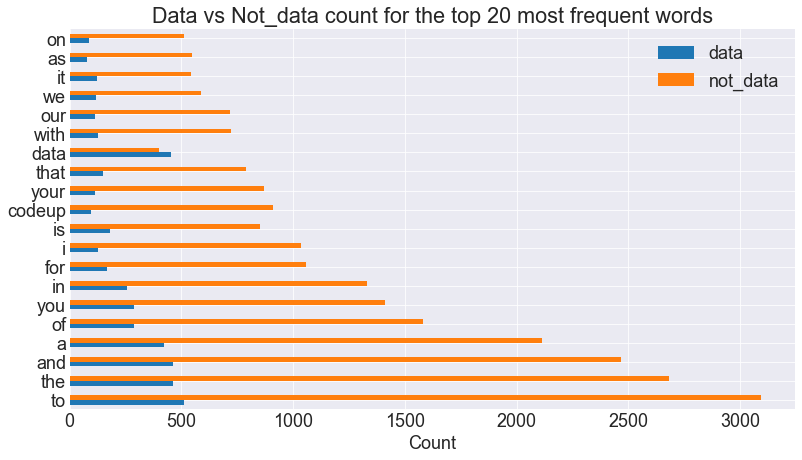

<Figure size 1152x648 with 0 Axes>

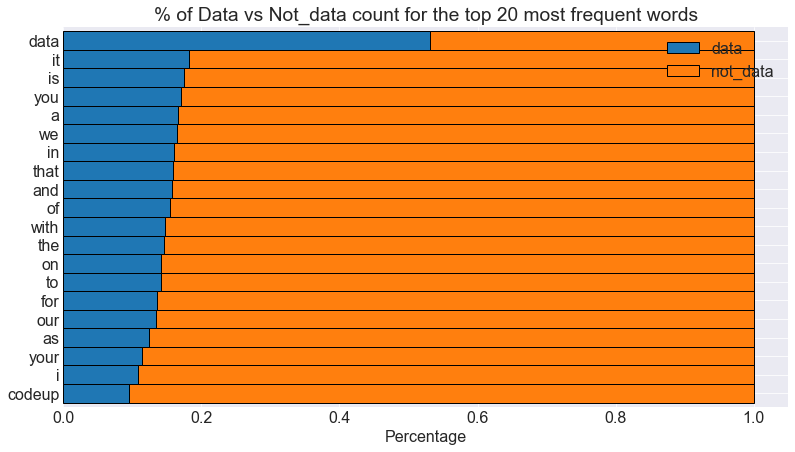

In [11]:
# Plot all hplot word plots
Blog.hplot_word_freq_viz()

# Plot stacked barplot frequency
Blog.stacked_bplot_freq()

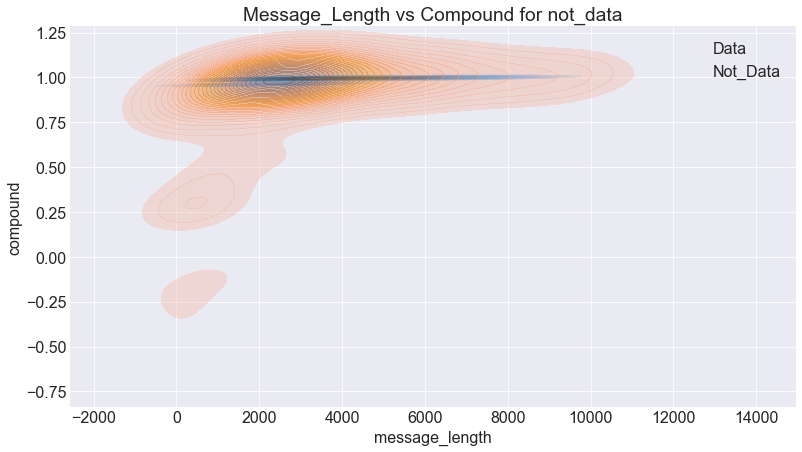

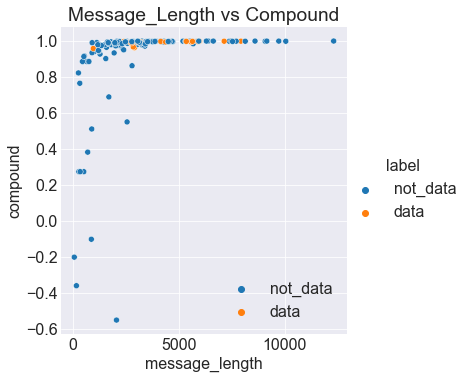

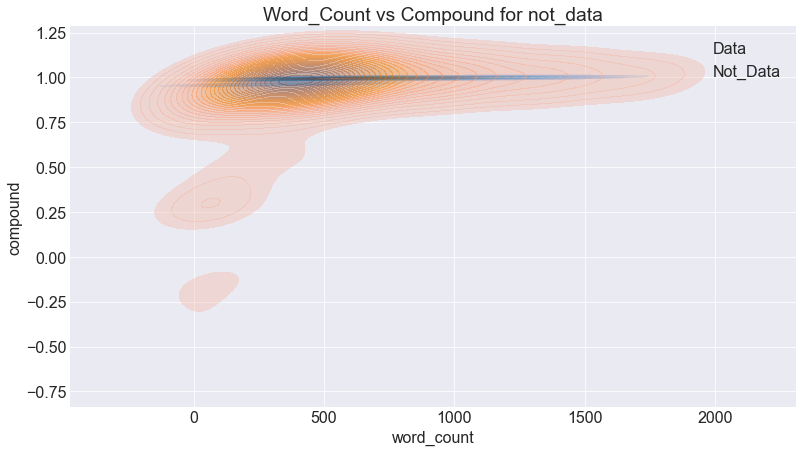

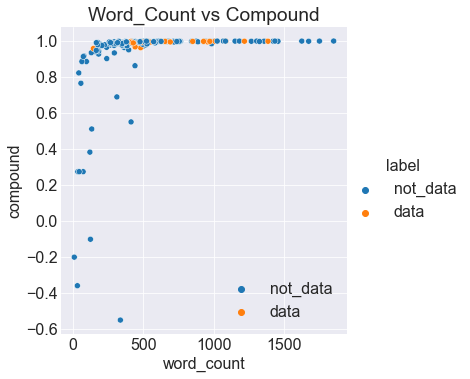

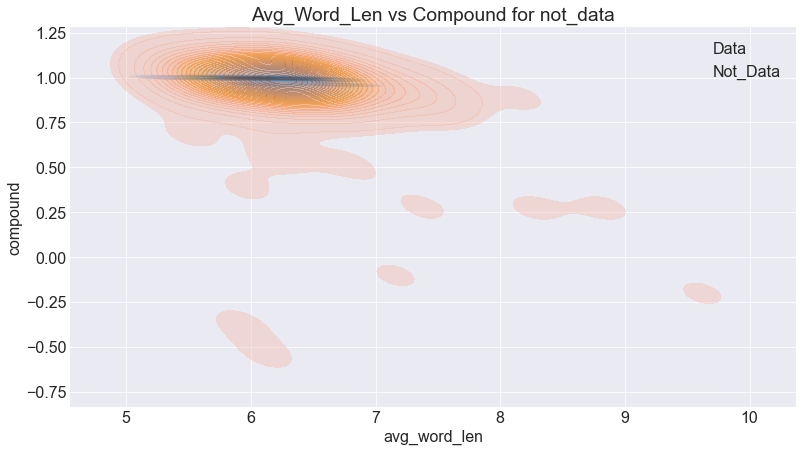

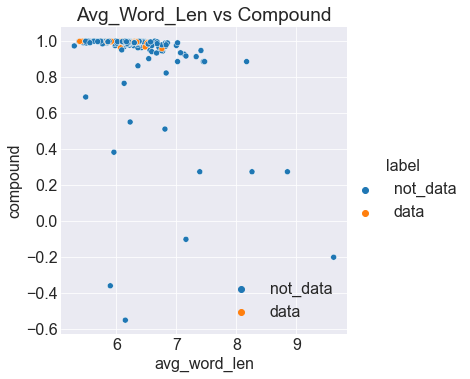

In [12]:
# Generate all default features 
Blog.add_features()
# Generate all sentiment analysis
Blog.add_sentiment_analysis()
# Plot the bivariate plots KDE
Blog.sentiment_bivariate_plots(alpha=.4)

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the `category` variable when exploring.

In [17]:
# Pull in dataframe 
news_df = get_news_articles(1000)
# Category label
test_label = 'Entertainment News'
label = test_label.lower().replace(' ', '_')
not_label = f'not_{label}'
# Check if there is the string 'Entertainment News' in category
def filter_categories(s):
    try:
        # Pull title string and split to check what words are in the title
        t = s['category']

        # Check if the word blog is in the title to filter into a category
        if test_label in t:
            return label
        else:
            # If it's not in it will label return not __label__
            return not_label
    except:
        # If it's not in it will label return not __label__
        return not_label

news_df['label'] = news_df.apply(filter_categories, axis=1)
news_df.head()

,parsed,news_articles,title,date,author,category,label
url,,,,,,,
https://inshorts.com/en/news/airstrike-hits-capital-of-ethiopias-tigray-3-killed-report-1635433206925,True,"An Ethiopian airstrike reportedly hit Mekelle,...",Airstrike hits capital of Ethiopia's Tigray; 3...,"28 Oct 2021,Thursday",Dharini MudgalDharini Mudgal,World News,not_entertainment_news
https://inshorts.com/en/read/politics,True,NCB officer Sameer Wankhede's wife and actress...,Political News: Government Politics News in En...,"27 Oct 2021,Wednesday28 Oct 2021,Thursday29 Oc...",Shalini OjhaShalini OjhaApaar SharmaApaar Shar...,None,not_entertainment_news
https://inshorts.com/en/read/automobile,True,Tesla CEO and the world's richest person Elon ...,Automobile News: Latest Car and Bike News Upda...,"26 Oct 2021,Tuesday26 Oct 2021,Tuesday24 Oct 2...",Pragya SwastikPragya SwastikKiran KhatriKiran ...,None,not_entertainment_news
https://inshorts.com/en/read/science,True,"'Star Trek' actor William Shatner, who became ...",Science News: Latest Science News Updates in E...,"16 Oct 2021,Saturday23 Oct 2021,Saturday28 Oct...",Daisy MowkeDaisy MowkeAnkush VermaAnkush Verma...,None,not_entertainment_news
https://inshorts.com/en/read/hatke,True,The Indian Railways on Wednesday shared a post...,Hatke News: Entertainment and Celebrity News U...,"20 Oct 2021,Wednesday19 Sep 2021,Sunday27 Sep ...",Pragya SwastikPragya SwastikPragya SwastikPrag...,None,not_entertainment_news


### Look into the data after we have fully pulled and cleaned most of the data in and identified the categories

In [18]:
# Create news article instances and run all meterics for the NLP
News = NLP_explore(news_df, 'label', 'news_articles', label, not_label)
# Look into the word counts
News.word_counts.head(5)

,entertainment_news,not_entertainment_news,all
the,115,2045,2160
in,61,905,966
to,60,1050,1110
a,57,937,994
of,52,880,932


### Look into the n_grams of variying length

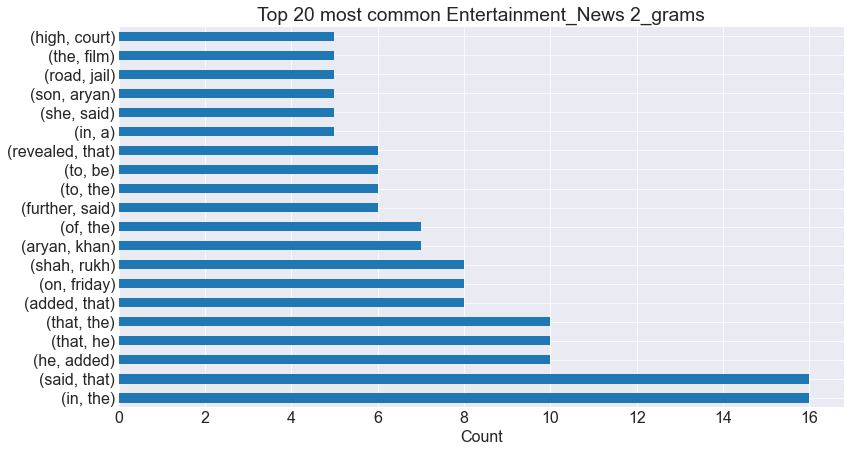

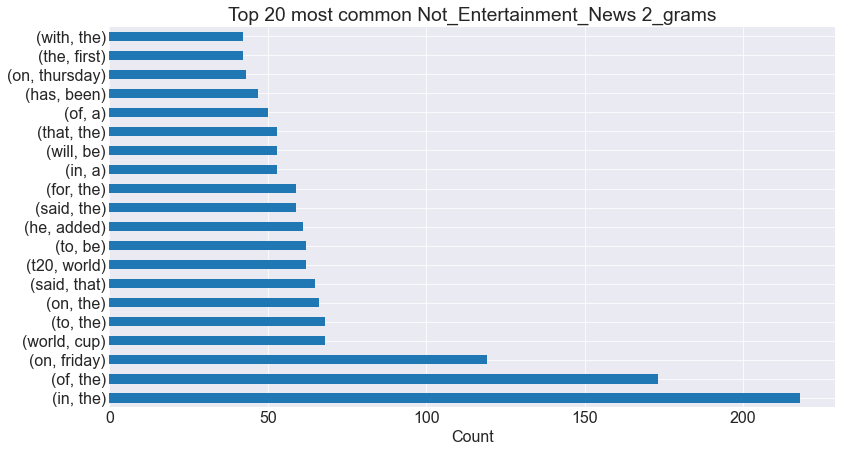

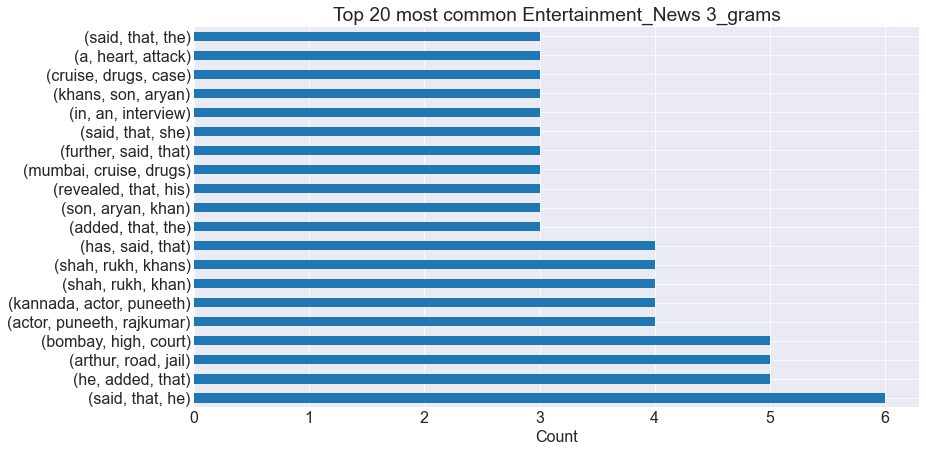

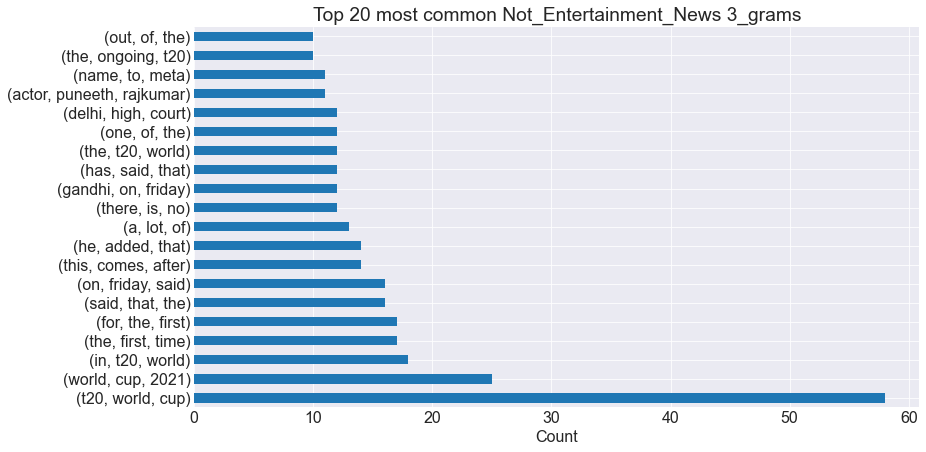

In [19]:
# Generate a bigram for the current category
bigram_label = News.n_gram(col=label)
# Generate a bigram for the non current category
bigram_not_label = News.n_gram(col=not_label)

# Generate a bigram for the current category
trigram_label = News.n_gram(col=label, n=3)
# Generate a bigram for the non current category
trigram_not_label = News.n_gram(col=not_label, n=3)

## Look into various wordclouds for the news articles

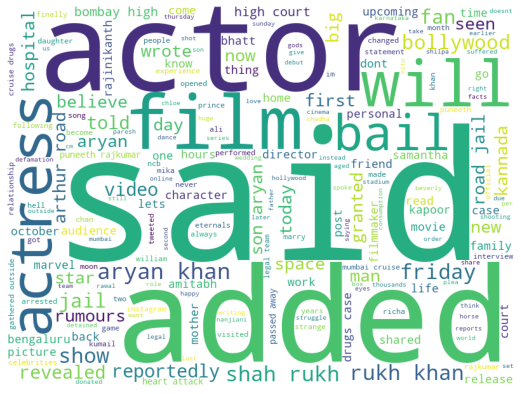

In [20]:
# Look at wordcloud for the current column
News.plot_wordcloud(col=label)

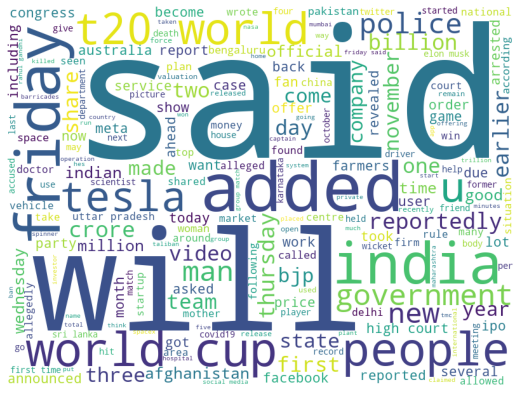

In [21]:
# Look at the wordcloud for the non-current cloud
News.plot_wordcloud(col=not_label)

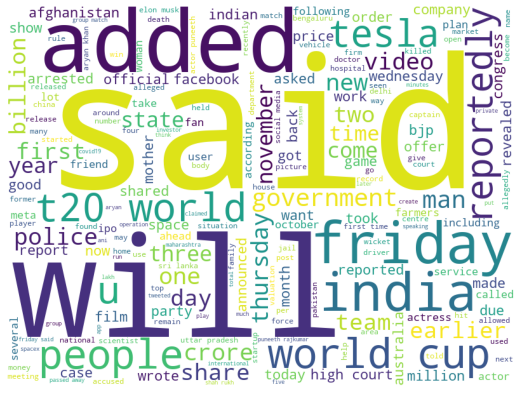

In [22]:
# Look at the wordcloud for the non-current cloud
News.plot_wordcloud()

## Examine the barchars of the various counts of the words

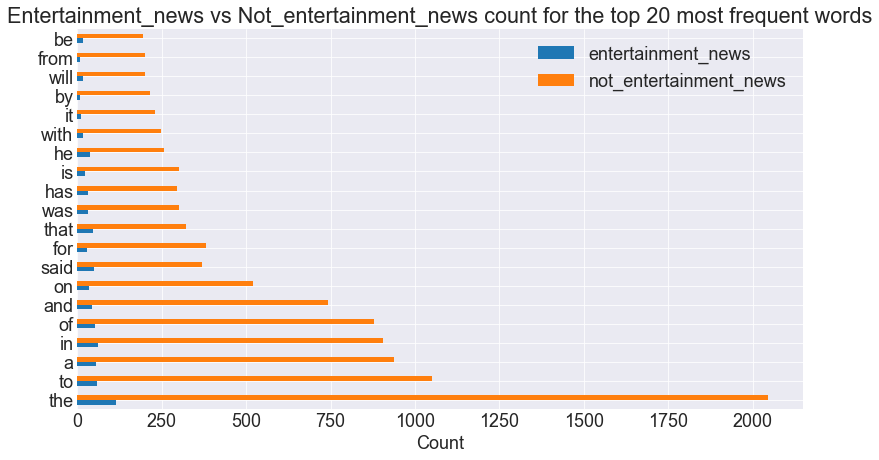

<Figure size 1152x648 with 0 Axes>

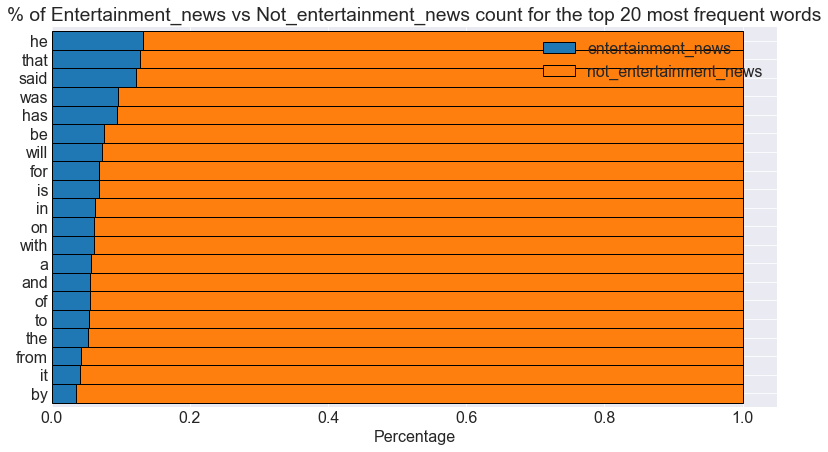

In [27]:
# Plot all hplot word plots 
News.hplot_word_freq_viz()

# Plot stacked barplot frequency
News.stacked_bplot_freq()

### Examine bivariate plots and analysis

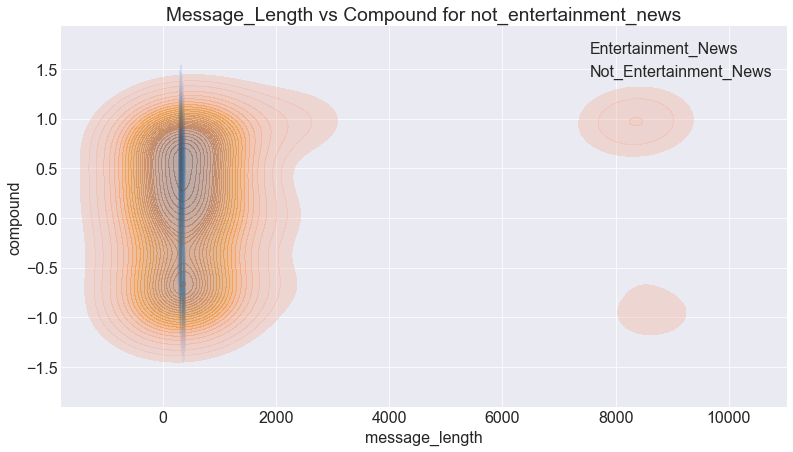

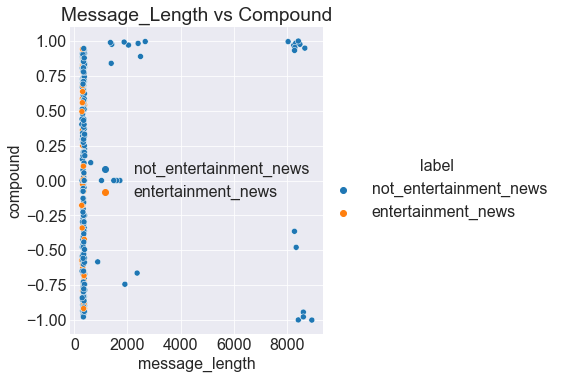

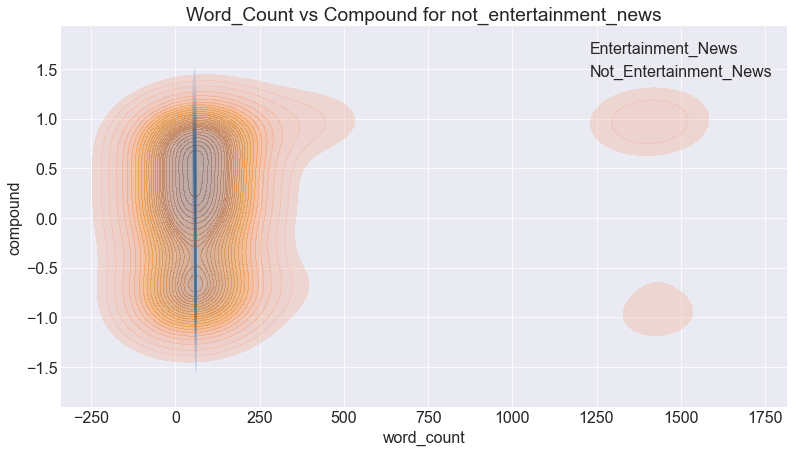

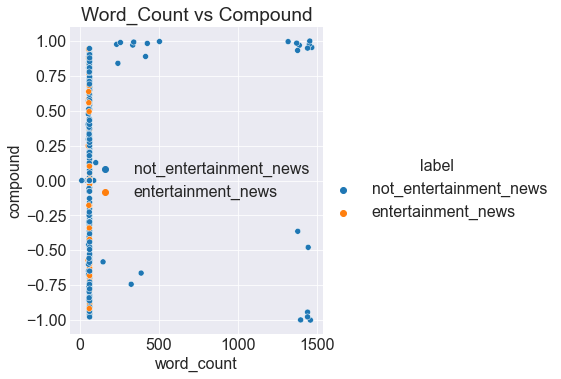

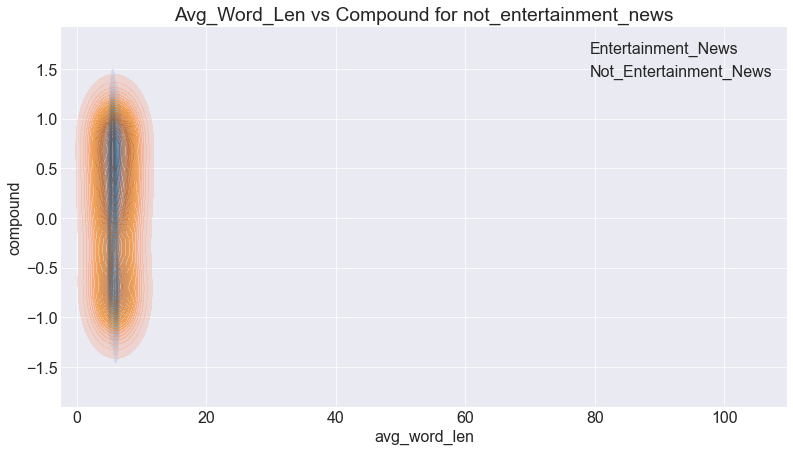

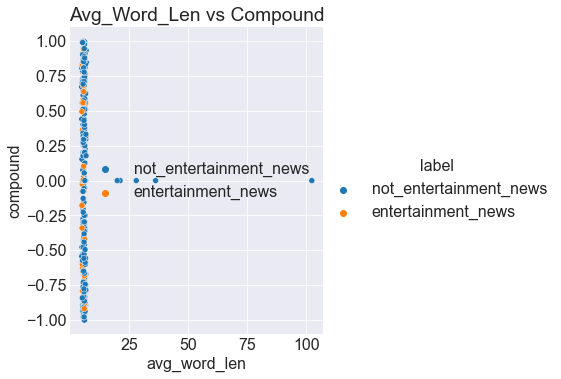

In [28]:
# Generate all default features 
News.add_features()
# Generate all sentiment analysis
News.add_sentiment_analysis()
# Plot the bivariate plots KDE
News.sentiment_bivariate_plots(alpha=.4)